# Project 4: Movie Recommendation

This project builds a Movie Recommender using the MovieLens 1M Dataset. We decided to use Python v3.9 for this project. We use the popular StreamLit library (https://streamlit.io/) to implement our App and the free StreamLit Cloud service (https://streamlit.io/cloud) to host the App. The project is delivered in three parts:

- System I: recommendation based on genres (this notebook)
- System II: collaborative recommendation system (this notebook)
- A Movie Recommendation App: hosted at https://share.streamlit.io/ratchahan/movie_recommender_cs598/recommender.py

This Jupyter Notebook and the code for the App are hosted on our GitHub Repository: https://github.com/ratchahan/movie_recommender_CS598

## Data Exploration

In this section, we will explore the MovieLens 1M Dataset and perform any preprocessing necessary before building our recommender models.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
dataset_dir = './data'

In [6]:
# Load the ratings table as a Pandas dataframe and add the column names

ratings_df = pd.read_csv('./data/ratings.dat', 
                       sep='::', 
                       engine='python', 
                       header=None,
                       names=["UserID", "MovieID", "Rating", "Timestamp"])

In [7]:
ratings_df

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [8]:
# Load the users table as a Pandas dataframe and add the column names

users_df = pd.read_csv('./data/users.dat', 
                       sep='::', 
                       engine='python', 
                       header=None,
                       names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

In [9]:
users_df

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [10]:
# Create maps for interesting demographics info

age_map = {1:  "Under 18",
           18:  "18-24",
           25:  "25-34",
           35:  "35-44",
           45:  "45-49",
           50:  "50-55",
           56:  "56+"}

In [11]:
occupation_map = {
    0:  "other",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "K-12 student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales/marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician/engineer",
    18:  "tradesman/craftsman",
    19:  "unemployed",
    20:  "writer"
}

In [12]:
# Load the movies table as a Pandas dataframe and add the column names

movies_df = pd.read_csv('./data/movies.dat', 
                       sep='::', 
                       engine='python', 
                       header=None,
                       encoding='latin-1',
                       names=["MovieID", "Title", "Genres"])

In [13]:
# The Genre column is in '\' separated form - it will be useful to convert this into a list

movies_df['Genres'] = movies_df['Genres'].apply(lambda x: x.split("|"))

movies_df

,MovieID,Title,Genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy]
3879,3949,Requiem for a Dream (2000),[Drama]
3880,3950,Tigerland (2000),[Drama]
3881,3951,Two Family House (2000),[Drama]


In [14]:
# Let's join the ratings and movies dataframes so that all the info we need are in one place

merged_df = ratings_df.join(movies_df.set_index('MovieID'), on='MovieID')

merged_df

,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),[Drama]
1,1,661,3,978302109,James and the Giant Peach (1996),"[Animation, Children's, Musical]"
2,1,914,3,978301968,My Fair Lady (1964),"[Musical, Romance]"
3,1,3408,4,978300275,Erin Brockovich (2000),[Drama]
4,1,2355,5,978824291,"Bug's Life, A (1998)","[Animation, Children's, Comedy]"
...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,Weekend at Bernie's (1989),[Comedy]
1000205,6040,1094,5,956704887,"Crying Game, The (1992)","[Drama, Romance, War]"
1000206,6040,562,5,956704746,Welcome to the Dollhouse (1995),"[Comedy, Drama]"
1000207,6040,1096,4,956715648,Sophie's Choice (1982),[Drama]


In [15]:
# Now we will expand the list of genre into a sparse matrix form (i.e., featurization)
# For example, the first movie "Toy Story" has ones in Animation, Children's, Comedy columns and
# zeros in all other columns

genres = set(genre for genres in movies_df['Genres'] for genre in genres)

for genre in genres:
    movies_df[genre] = movies_df.Genres.transform(lambda x: int(genre in x))

In [16]:
movies_df

,MovieID,Title,Genres,Musical,Horror,Action,Documentary,Romance,Crime,Thriller,...,Animation,Film-Noir,Drama,Western,Children's,Adventure,Fantasy,Mystery,Sci-Fi,Comedy
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3879,3949,Requiem for a Dream (2000),[Drama],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3880,3950,Tigerland (2000),[Drama],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3881,3951,Two Family House (2000),[Drama],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [17]:
# The complete list of Genre in our dataset (from the dataset spec). 

genre_list = ["Action", 
              "Adventure",
              "Animation",
              "Children's",
              "Comedy",
              "Crime",
              "Documentary",
              "Drama",
              "Fantasy",
              "Film-Noir",
              "Horror",
              "Musical",
              "Mystery",
              "Romance",
              "Sci-Fi",
              "Thriller",
              "War",
              "Western"]

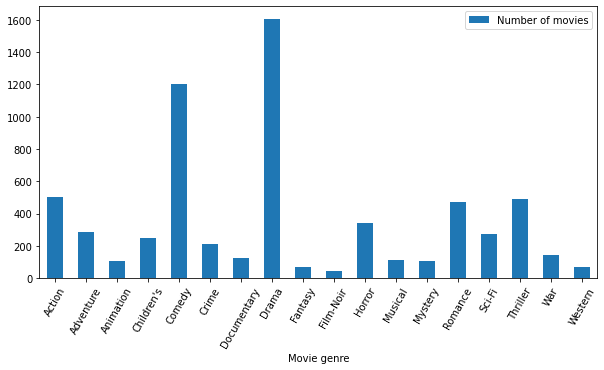

In [18]:
# Let's visualize the distribution of genre across all the movies
# This will a useful info as we build our System I: Genres based Recommender

count = []
for i in genre_list:
    genre_based_movies = movies_df[['MovieID', 'Title', i]]
    genre_based_movies = genre_based_movies[genre_based_movies[i] == 1]
    count.append(len(genre_based_movies))

df = pd.DataFrame({'Movie genre': genre_list, 'Number of movies': count})
ax = df.plot.bar(x='Movie genre', y='Number of movies', rot=60, figsize=(10, 5))

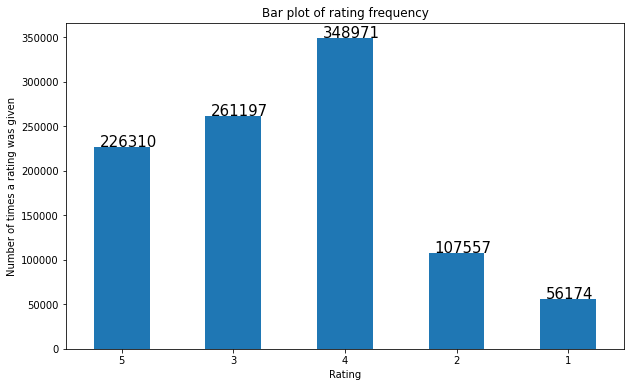

In [19]:
# Finally, we can visualize the distribution of ratings accross all the movies

ratings_df['Rating'].value_counts(sort=False).plot(kind='bar' ,figsize=(10,6), use_index = True, rot=0)
plt.title('Bar plot of rating frequency')
plt.xlabel('Rating')
plt.ylabel('Number of times a rating was given')
label = list(ratings_df['Rating'].value_counts(sort=False))
r4 = [1,2,3,4,5]
for i in range(len(label)):
  plt.text(x = r4[i]-1.2, y = label[i]+500, s = label[i], size =15)

## System I - Genres based Recommender

In this section we will build a Genres based Recommender system. This will help us with the "cold start" problem in recommender systems. That is, recommending a movie to a new user who has not rated any movies. However, if we know about the user's broad interest in a particular genre we can then recommend some interesting movies based on genre.

In [20]:
# First we will generate a list of highly rated movies by computing the average rating per movie

avg_highly_rated_movies = merged_df.groupby(['Title']).agg({"Rating":"mean"})['Rating'].sort_values(ascending=False)
        
avg_highly_rated_movies = avg_highly_rated_movies.to_frame()

In [21]:
avg_highly_rated_movies

,Rating
Title,
Ulysses (Ulisse) (1954),5.0
Lured (1947),5.0
Follow the Bitch (1998),5.0
Bittersweet Motel (2000),5.0
Song of Freedom (1936),5.0
...,...
"Fantastic Night, The (La Nuit Fantastique) (1949)",1.0
Cheetah (1989),1.0
Torso (Corpi Presentano Tracce di Violenza Carnale) (1973),1.0


In [22]:
# Transform the dataframe to have proper column headings

avg_highly_rated_movies.reset_index(level=0, inplace=True)
avg_highly_rated_movies.columns = ['Title', 'AvgRating']
avg_highly_rated_movies.head(10)

,Title,AvgRating
0,Ulysses (Ulisse) (1954),5.0
1,Lured (1947),5.0
2,Follow the Bitch (1998),5.0
3,Bittersweet Motel (2000),5.0
4,Song of Freedom (1936),5.0
5,One Little Indian (1973),5.0
6,Smashing Time (1967),5.0
7,Schlafes Bruder (Brother of Sleep) (1995),5.0
8,"Gate of Heavenly Peace, The (1995)",5.0
9,"Baby, The (1973)",5.0


In [23]:
# First we will generate a list of popular movies by computing the number of users who watched them

popular_movies = merged_df.groupby(['Title']).agg({"Rating":"count"})['Rating'].sort_values(ascending=False)

In [24]:
popular_movies = popular_movies.to_frame()
popular_movies.reset_index(level=0, inplace=True)
popular_movies.columns = ['Title', 'UserCount']

In [25]:
popular_movies.head(10)

,Title,UserCount
0,American Beauty (1999),3428
1,Star Wars: Episode IV - A New Hope (1977),2991
2,Star Wars: Episode V - The Empire Strikes Back...,2990
3,Star Wars: Episode VI - Return of the Jedi (1983),2883
4,Jurassic Park (1993),2672
5,Saving Private Ryan (1998),2653
6,Terminator 2: Judgment Day (1991),2649
7,"Matrix, The (1999)",2590
8,Back to the Future (1985),2583
9,"Silence of the Lambs, The (1991)",2578


We see that movies ranked by average rating and user count produces significantly different list. Let's explore why by merging the two dataframes.

In [26]:
# Merge the two dataframe to see the relationship between AvgRating and UserCount

highly_rated_popular_movies = pd.merge(avg_highly_rated_movies, popular_movies, how='inner', on='Title')
highly_rated_popular_movies.head(20)

,Title,AvgRating,UserCount
0,Ulysses (Ulisse) (1954),5.000000,1
1,Lured (1947),5.000000,1
2,Follow the Bitch (1998),5.000000,1
3,Bittersweet Motel (2000),5.000000,1
4,Song of Freedom (1936),5.000000,1
5,One Little Indian (1973),5.000000,1
6,Smashing Time (1967),5.000000,2
7,Schlafes Bruder (Brother of Sleep) (1995),5.000000,1
8,"Gate of Heavenly Peace, The (1995)",5.000000,3
9,"Baby, The (1973)",5.000000,1


We can see from this list that many 5 star rated movies have only one reviewer! Our recommender has to take both measures into account to produce relevant recommendations.

In [27]:
# Get highly rated movies with enough ratings. This threshold can be a hyperparameter in our system. 
# As we saw earlier, a genre like "Film-Noir" has very few moviews so we need to adjust the user count accordingly.

highly_rated_popular_movies[highly_rated_popular_movies['UserCount']>2000]

,Title,AvgRating,UserCount
15,"Shawshank Redemption, The (1994)",4.554558,2227
16,"Godfather, The (1972)",4.524966,2223
19,Schindler's List (1993),4.510417,2304
30,Raiders of the Lost Ark (1981),4.477725,2514
33,Star Wars: Episode IV - A New Hope (1977),4.453694,2991
42,"Sixth Sense, The (1999)",4.406263,2459
59,"Silence of the Lambs, The (1991)",4.351823,2578
63,Saving Private Ryan (1998),4.337354,2653
75,American Beauty (1999),4.317386,3428
76,"Matrix, The (1999)",4.315830,2590


In [28]:
# Emperically, this list looks like a good one to recommend our movies from. 
# We will save this list for use in our app. This list is also a good candidate
# for obtaining reviews from new users (as they are likely to have seen several)

In [29]:
selected_movies_df = highly_rated_popular_movies[(highly_rated_popular_movies['UserCount']>1000) 
                                                 & (highly_rated_popular_movies['AvgRating']>=4.0)]

In [30]:
selected_movies_df.to_csv('models/selected_movies_df.csv', sep='\t', index=False, header=True)

In [31]:
# In order to add some variablity and interestingness, it will be good to ramdomly sample
# from this for recommendations. Pandas makes this very simple.

selected_movies_df = selected_movies_df.sample(frac=1).reset_index(drop=True)

These are the popular moview we can recommend to new users.

In [32]:
# Note: the results here vary somewhat based on the previous sample step.

selected_movies_df.head(10)

,Title,AvgRating,UserCount
0,When Harry Met Sally... (1989),4.073342,1568
1,Dr. Strangelove or: How I Learned to Stop Worr...,4.449890,1367
2,Gladiator (2000),4.106029,1924
3,"Godfather, The (1972)",4.524966,2223
4,"Terminator, The (1984)",4.152050,2098
5,"Silence of the Lambs, The (1991)",4.351823,2578
6,"Untouchables, The (1987)",4.007986,1127
7,Pulp Fiction (1994),4.278213,2171
8,Seven (Se7en) (1995),4.106420,1137
9,Butch Cassidy and the Sundance Kid (1969),4.215645,1419


### Genre based Recommender - Implementation

In this section, we will implement the genre based recommender algorithm. This function will be used in the App.

In [33]:
def genre_visualization(df):
    df['Rating'].value_counts(sort=False).plot(kind='bar' ,figsize=(10,6), use_index = True, rot=0)
    plt.title('Bar plot of rating frequency')
    plt.xlabel('Rating')
    plt.ylabel('Number of times a rating was given')
    plt.show()
    print("Total number of users watched this Genre: ",len(df), '\n\n')

In [34]:
def recommend_by_genre(genre):
    if genre == "Surprise me!":
        x = genre_list[random.randint(1, len(genre_list)-1)]
    else:
        x = genre
    genre_based_movies = movies_df[['MovieID', 'Title', x]]
    genre_based_movies = genre_based_movies[genre_based_movies[x] == 1]
    merged_genre_movies = pd.merge(ratings_df, genre_based_movies, how='inner', on='MovieID')
    
    # Visualize results for this genre
    print('===================', genre, '===================', '\n')
    genre_visualization(merged_genre_movies)
    
    high_rated_movies = merged_genre_movies.groupby(['MovieID']).agg({"Rating":"mean"})['Rating'].sort_values(ascending=False)
    high_rated_movies = high_rated_movies.to_frame()

    popular_movies_ingenre = merged_genre_movies.groupby(['MovieID']).agg({"Rating":"count"})['Rating'].sort_values(ascending=False)
    popular_movies_ingenre = popular_movies_ingenre.to_frame()
    
    popular_movies_ingenre.reset_index(level=0, inplace=True)
    popular_movies_ingenre.columns = ['MovieID', 'UserCount']

    highly_rated_popular_movies = pd.merge(high_rated_movies, popular_movies_ingenre, how = 'inner', on='MovieID')
    
    viewer_limit = 1000
    ratings_limit = 3.9
    check = 0
    while viewer_limit > 0 and ratings_limit > 0:
        results = highly_rated_popular_movies[(highly_rated_popular_movies['UserCount']>viewer_limit) 
                                             & (highly_rated_popular_movies['Rating']>=ratings_limit)]
        if len(results) < 11:
            if check == 0:
                viewer_limit -= 100
                check = 1
            else:
                ratings_limit -= 0.1
                check = 0
        else:
            break
    
    results = results.sample(frac=1).reset_index(drop=True)
    movie_ids = results["MovieID"].tolist()
    # st.write('recommend_by_genre =', len(results), len(movie_ids))
    
    return movie_ids

=================== Crime =================== 



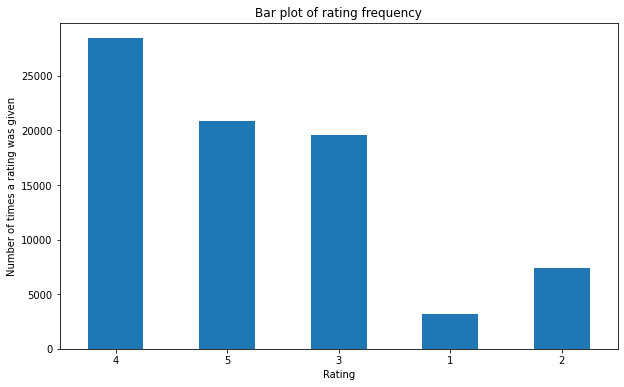

Total number of users watched this Genre:  79541 


=================== Documentary =================== 



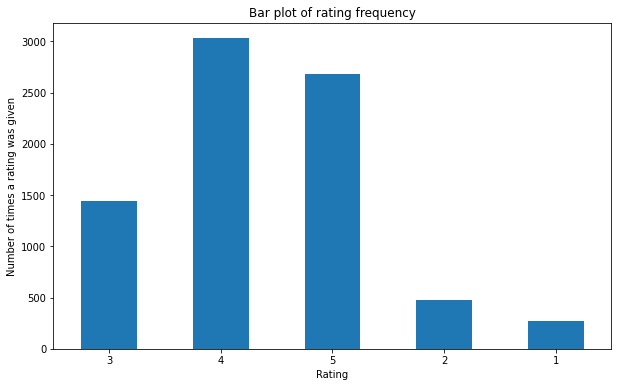

Total number of users watched this Genre:  7910 




In [35]:
# Let's check the results for a couple of genre

for i in genre_list[5:7]:
    movie_ids = recommend_by_genre(i)


=================== Action =================== 



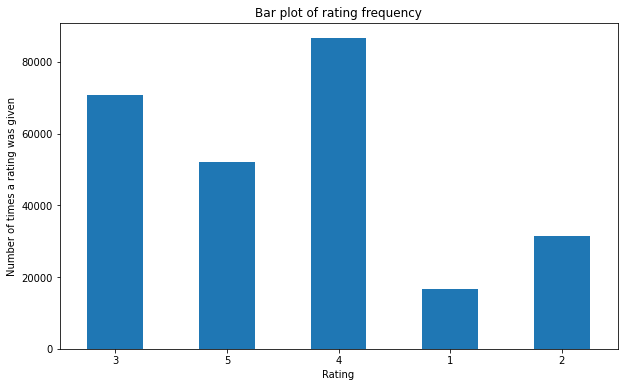

Total number of users watched this Genre:  257457 


Here are the genre based recommendation for Action


Star Wars: Episode V - The Empire Strikes Back (1980)
Rocky (1976)
Butch Cassidy and the Sundance Kid (1969)
Hunt for Red October, The (1990)
Matrix, The (1999)
Boat, The (Das Boot) (1981)
Die Hard (1988)
Princess Bride, The (1987)
Blues Brothers, The (1980)
Star Wars: Episode VI - Return of the Jedi (1983)
Terminator 2: Judgment Day (1991)
Star Wars: Episode IV - A New Hope (1977)
Run Lola Run (Lola rennt) (1998)
African Queen, The (1951)
Full Metal Jacket (1987)
Untouchables, The (1987)
Braveheart (1995)
Godfather, The (1972)
Fugitive, The (1993)
Indiana Jones and the Last Crusade (1989)
Godfather: Part II, The (1974)
Saving Private Ryan (1998)
Gladiator (2000)
Aliens (1986)
Terminator, The (1984)
Jaws (1975)
Glory (1989)
Alien (1979)
Raiders of the Lost Ark (1981)


In [40]:
movie_ids = recommend_by_genre('Action')

print('Here are the genre based recommendation for Action\n\n')
for movie_id in movie_ids:
    print(movies_df.loc[movies_df['MovieID'] == movie_id, 'Title'].values[0])

In [44]:
# Save for use in the app

movies_df.to_csv('models/movies_df.csv', sep='\t', index=False, header=True)

In [45]:
# Save for use in the app

ratings_df.to_csv('models/ratings_df.csv', sep='\t', index=False, header=True)

## System II - Collaborative Recommendation System

In this part of the project, we will explore Collaborative Filtering algorithms and build an app to demonstrate the features.

In [47]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

In [ ]:
new_user = 10000

Let's reload the datasets to start this part with a clean slate.

In [48]:
ratings_df = pd.read_csv('data/ratings.dat', 
                       sep='::', 
                       engine='python', 
                       header=None,
                       names=["UserID", "MovieID", "Rating", "Timestamp"])

In [49]:
users_df = pd.read_csv('data/users.dat', 
                       sep='::', 
                       engine='python', 
                       header=None,
                       names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

In [50]:
movies_df = pd.read_csv('data/movies.dat', 
                       sep='::', 
                       engine='python', 
                       header=None,
                       encoding='latin-1',
                       names=["MovieID", "Title", "Genres"])

In [51]:
# Preprocess the ratings into a sparse matrix form

movies_df['Genres'] = movies_df['Genres'].apply(lambda x: x.split("|"))
merged_df = ratings_df.join(movies_df.set_index('MovieID'), on='MovieID')

genres = set(genre for genres in movies_df['Genres'] for genre in genres)

for genre in genres:
    movies_df[genre] = movies_df.Genres.transform(lambda x: int(genre in x))

Most collaborative filtering methods expoit the relationship between movies and users. First,  we will generate a sparse matrix from ratings dataframe containing 3 columns (UserId, MovieId, Rating). The next method returns the following info:

- X: sparse matrix
- user_mapper: dict that maps user id's to user indices
- user_inv_mapper: dict that maps user indices to user id's
- movie_mapper: dict that maps movie id's to movie indices
- movie_inv_mapper: dict that maps movie indices to movie id's

In [71]:
def create_X(df):

    M = df['UserID'].nunique()
    N = df['MovieID'].nunique()

    user_mapper = dict(zip(np.unique(df["UserID"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["MovieID"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["UserID"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["MovieID"])))

    user_index = [user_mapper[i] for i in df['UserID']]
    item_index = [movie_mapper[i] for i in df['MovieID']]

    X = csr_matrix((df["Rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [55]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings_df)

In [56]:
# The shape of the X matrix should be (#users x #movies)

X.shape

(6040, 3706)

The first algorithm we will explore is K Nearest Neighbors. The next method finds k-nearest neighbours for a given movie id. It returns a list of k similar movie ID's.

- movie_id: id of the movie of interest
- X: user-item utility matrix
- k: number of similar movies to retrieve
- metric: distance metric for kNN calculations

In [57]:
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

### Matrix Factorization Recommender

We will expore the Truncated SVD algorithm for our recommender. SVD based matrix factorization method can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. The relationship between movies and users is very sparse and matrix factorization is particularly useful for enhancing the quality of recommendations.

The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

In [58]:
# This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). 
# This means it can work with sparse matrices efficiently.

svd = TruncatedSVD(n_components=20, n_iter=10)
Z = svd.fit_transform(X.T)

In [59]:
# Test our model with a few samples

movie_id = 9
similar_movies = find_similar_movies(movie_id, Z.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movies_df.loc[movies_df['MovieID'] == movie_id, 'Title'].values[0]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    row = movies_df.loc[movies_df['MovieID'] == i, 'Title'].values[0]
    print(row)

Because you watched Sudden Death (1995):
Drop Zone (1994)
Money Train (1995)
Under Siege 2: Dark Territory (1995)
Terminal Velocity (1994)
Specialist, The (1994)
Fair Game (1995)
Fled (1996)
Marked for Death (1990)
Metro (1997)


Truncated singular value decomposition (SVD) is a good tool to reduce dimensionality of our feature matrix especially when applied on the sparse user-movie matrix. As seen from the explained variance graph below, with 20 latent components we can explain more than 37% of variance in the data.

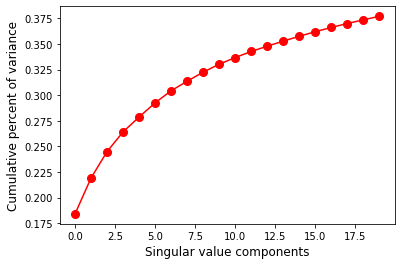

In [64]:
svd = TruncatedSVD(n_components=20)
latent_matrix = svd.fit_transform(X.T)
 
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

As seen from the explained variance graph below, with 200 latent components we can explain more than 60% of variance in the data which suffices for our purpose in this work. 

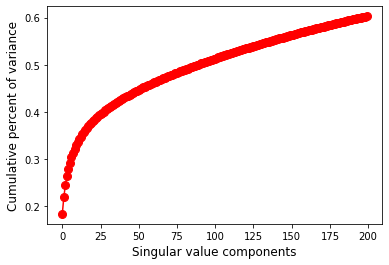

In [65]:
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(X.T)
 
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

### Predict Movie Ratings for new users

With matrix factorization, we can  predict missing ratings in our user-item matrix for new users. We can do this by reconstructing our matrix by getting the inner product of our user-factor matrix and movie-factor matrix. We can use the inverse_transform on our movie-factor matrix Z to get our reconstructed user-item matrix.

In [67]:
# Let's assume a new user have generated the following five ratings from a list of sample movies
# ratings_df <-- add the new user with id 10000
# UserID, MovieID, Rating, Timestamp
new_ratings_df = ratings_df.append([{'UserID' : 10000, 'MovieID' : 25, 'Rating': 5},
                                    {'UserID' : 10000, 'MovieID' : 10, 'Rating': 4},
                                    {'UserID' : 10000, 'MovieID' : 150, 'Rating': 5},
                                    {'UserID' : 10000, 'MovieID' : 200, 'Rating': 1},
                                    {'UserID' : 10000, 'MovieID' : 70, 'Rating': 3}], ignore_index=True)

len(new_ratings_df)

1000214

In [68]:
# We can use this info to predict ratings for other movies for this new user

new_X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(new_ratings_df)
new_Z = svd.fit_transform(new_X.T)
pred_X = svd.inverse_transform(new_Z).T

In [69]:
# Let's try predicting other movies for this user:

UserID = 10000
user_preferences = new_ratings_df[(new_ratings_df['UserID']==UserID)&(new_ratings_df['Rating']>=1)]
user_preferences = user_preferences.merge(movies_df[['MovieID', 'Title']])
user_preferences.sort_values('Rating', ascending=False).head(10)

,UserID,MovieID,Rating,Timestamp,Title
0,10000,25,5,NaN,Leaving Las Vegas (1995)
2,10000,150,5,NaN,Apollo 13 (1995)
1,10000,10,4,NaN,GoldenEye (1995)
4,10000,70,3,NaN,From Dusk Till Dawn (1996)
3,10000,200,1,NaN,"Tie That Binds, The (1995)"


In [70]:
# This method takes ratings from a new user and predicts similar movies

def predict_movies(df, rated_movies):
    results = []
    top_N = 50
    X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(df)
    svd = TruncatedSVD(n_components=20, n_iter=10)
    Z = svd.fit_transform(X.T)
    pred = svd.inverse_transform(Z).T
    top_N_movies = pred[user_mapper[my_userid]].argsort()[-top_N:]
    
    # print(f"Top {top_N} Recommendations for UserId {my_userid}:")
    for i in top_N_movies:
        movie_id = movie_inv_mapper[i]
        # Remove movies already watched by user
        if not movie_id in rated_movies:
            results.append(movie_id)
            # st.write(movie_titles[movie_id])
    return results

We will use this method in our App to predict movies for a new user.

## References:
   
- https://beckernick.github.io/matrix-factorization-recommender/
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
- https://blog.codecentric.de/en/2019/07/recommender-system-movie-lens-dataset/
- https://www.jillcates.com/pydata-workshop/html/tutorial.html
- https://streamlit.io/gallery
